In [1]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os

In [2]:
def filename_extractor(path):
    del filenames[:]
    for i in os.listdir(path+'Melanoma'):
        filenames.append('Melanoma/' + i)
    for i in os.listdir(path+'NotMelanoma'):
        filenames.append('NotMelanoma/' + i)

In [3]:
Image_Width=600
Image_Height=400
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size = 32
filenames = []

In [4]:
train_images = []
train_labels = []
train_path = './DermMel/train_sep/'

for root, dirs, files in os.walk(train_path):

    for name in dirs:
        direct = os.path.join(train_path, name)
        for filename in os.listdir(direct):
            img = cv.imread(os.path.join(train_path + "/" + name, filename))
            train_labels.append(name)
            img = cv.resize(img, Image_Size)
            train_images.append(img)

### Train Data

In [5]:
filename_extractor(train_path)
train_df = pd.DataFrame({
    'filename' : filenames,
    'category' : train_labels
})
train_df

,filename,category
0,Melanoma/AUGmented_0_1000.jpeg,Melanoma
1,Melanoma/AUGmented_0_1007.jpeg,Melanoma
2,Melanoma/AUGmented_0_1009.jpeg,Melanoma
3,Melanoma/AUGmented_0_1022.jpeg,Melanoma
4,Melanoma/AUGmented_0_1029.jpeg,Melanoma
...,...,...
10677,NotMelanoma/ISIC_0034314.jpg,NotMelanoma
10678,NotMelanoma/ISIC_0034315.jpg,NotMelanoma
10679,NotMelanoma/ISIC_0034318.jpg,NotMelanoma
10680,NotMelanoma/ISIC_0034319.jpg,NotMelanoma


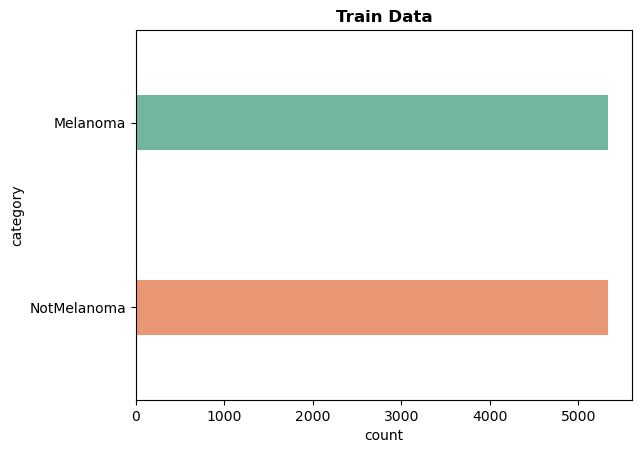

In [6]:
sns.countplot(data=train_df, y = 'category', width=0.3, palette = 'Set2')
plt.title('Train Data', weight='black')
plt.show()

In [7]:
test_images = []
test_labels = []
test_path = './DermMel/test/'

for root, dirs, files in os.walk(test_path):

    for name in dirs:
        direct = os.path.join(test_path, name)
        for filename in os.listdir(direct):
            img = cv.imread(os.path.join(test_path + "/" + name, filename))
            test_labels.append(name)
            img = cv.resize(img, Image_Size)
            test_images.append(img)

### Test Data

In [8]:
filename_extractor(test_path)
test_df = pd.DataFrame({
    'filename' : filenames,
    'category' : test_labels
})
test_df

,filename,category
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma
...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma


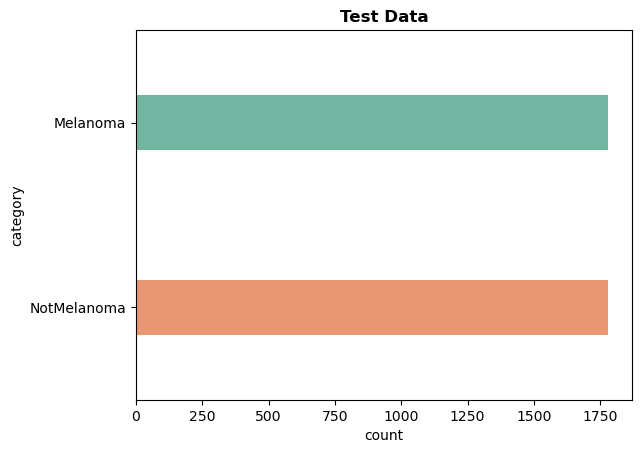

In [9]:
sns.countplot(data=test_df, y = 'category', width=0.3, palette = 'Set2')
plt.title('Test Data', weight='black')
plt.show()

In [10]:
validation_images = []
validation_labels = []
validation_path = './DermMel/valid/'

for root, dirs, files in os.walk(validation_path):

    for name in dirs:
        direct = os.path.join(validation_path, name)
        for filename in os.listdir(direct):
            img = cv.imread(os.path.join(validation_path + "/" + name, filename))
            validation_labels.append(name)
            img = cv.resize(img, Image_Size)
            validation_images.append(img)

### Validation Data

In [11]:
filename_extractor(validation_path)
val_df = pd.DataFrame({
    'filename' : filenames,
    'category' : validation_labels
})
val_df

,filename,category
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma
...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma


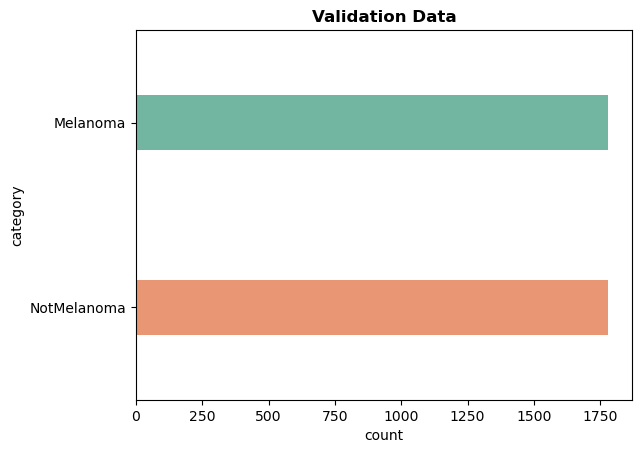

In [12]:
sns.countplot(data=test_df, y = 'category', width=0.3, palette = 'Set2')
plt.title('Validation Data', weight='black')
plt.show()

In [13]:
train_path

'./DermMel/train_sep/'

In [14]:
#preprocessing
train_datag=ImageDataGenerator(rescale=1./ 255)#rescalling

train_dataset=train_datag.flow_from_dataframe(dataframe=train_df, #data_frame of data
                                              directory=train_path, #path
                                              x_col="filename",
                                              y_col="category",
                                              target_size=Image_Size, #resize image it doesnt mean converting into 2d we can give only height and breadth
                                              batch_size=32, #by default 32
                                              validate_filenames= False
                                             )

Found 10682 non-validated image filenames belonging to 2 classes.


In [15]:
test_datag=ImageDataGenerator(rescale=1./255)
test_dataset=test_datag.flow_from_dataframe(dataframe=test_df,
                                            directory=test_path,
                                            x_col="filename",
                                            y_col="category",
                                            target_size=Image_Size,
                                            batch_size=32,
                                            validate_filenames=False
                                           )

Found 3561 non-validated image filenames belonging to 2 classes.


In [16]:
train_dataset.class_indices #gives the class of target values

{'Melanoma': 0, 'NotMelanoma': 1}

In [17]:
train_dataset[0][0].shape# 0 batch# 32 batches 128-h 128-w,3d image

(32, 600, 400, 3)

In [18]:
model=Sequential([
    Input(shape=(Image_Width, Image_Height, Image_Channels)),
    #con layer1
    Conv2D(filters=16 ,kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"),#no.of kernels,k.size,strides,padding=same keeps input ouput same size valid means no padding
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    #conv layer-2
    Conv2D(filters=32, kernel_size=(3,3),activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    
    #conv layer-3
    Conv2D(filters=32, kernel_size=(3,3),activation="relu"),
    BatchNormalization(),    
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    #FLATTENNING
    Flatten(),
    
    #NN
    Dense(units=64,activation="relu"),
    Dense(units=32,activation="relu"),
    
    
    #output layer
    Dense(units=2,activation="softmax")
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 598, 398, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 598, 398, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 199, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 299, 199, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 197, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 297, 197, 32)     1

In [19]:
model.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy"])

In [20]:
model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
334/334 [==============================] - 717s 2s/step - loss: 1.1068 - accuracy: 0.7700 - val_loss: 5.2782 - val_accuracy: 0.5723
Epoch 2/30
334/334 [==============================] - 673s 2s/step - loss: 0.3015 - accuracy: 0.8778 - val_loss: 1.5469 - val_accuracy: 0.7633
Epoch 3/30
334/334 [==============================] - 672s 2s/step - loss: 0.2475 - accuracy: 0.9085 - val_loss: 6.2388 - val_accuracy: 0.6178
Epoch 4/30
334/334 [==============================] - 671s 2s/step - loss: 0.2109 - accuracy: 0.9145 - val_loss: 2.7894 - val_accuracy: 0.5611
Epoch 5/30
334/334 [==============================] - 673s 2s/step - loss: 0.2519 - accuracy: 0.9074 - val_loss: 1.2692 - val_accuracy: 0.8683
Epoch 6/30
334/334 [==============================] - 669s 2s/step - loss: 0.1833 - accuracy: 0.9274 - val_loss: 1.5537 - val_accuracy: 0.6917
Epoch 7/30
334/334 [==============================] - 670s 2s/step - loss: 0.1504 - accuracy: 0.9380 - val_loss: 0.7662 - val_accuracy: 0.8399

In [21]:
model.save_weights("melanoma-classifier.h5")
print("Saved model to disk")

Saved model to disk
